# TP5 Kernel Methods for Machine Learning

In [1]:
# setup
import numpy as np
#import pandas as pd
from sklearn import linear_model as lm
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import cross_val_score as cvs
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sys
print(sys.version)

3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:07:29) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
import sklearn
sklearn.__version__

'0.19.2'

## Tasks

### Non-linear SVMs and Kernel Trick

1. Generate a toy dataset where positive and negative examples are mixture of two Gaussians which are not linearly separable. You may use the code from TP4 to simulate data, but $\mu_1 = \mu_{-1} = 0, \sigma_1=1,\sigma_{-1}=10$.
2. Train a linear and a non-linear SVM (e.g. with a Gaussian RBF kernel) on this dataset, using the function `sklearn.svm.SVC`. Compare the training and testing errors of these two models. **Question: How are their performances so different?**
3. Focus on the SVM with a RBF kernel $k(x_i,x_j) = \exp\{-\frac{\|x_i-x_j\|^2}{2\sigma^2}\}$:
    1. Assess the effect of $\sigma$ on the produced similarity measure by inspecting the kernel matrix. **Question: What happens if $\sigma$ is too big or too small? What is a "good" $\sigma$ in terms of the produced similarity measure?**
    2. Assess the effect of $\sigma$ (as well as $C$) by plotting the training and test prediction errors. **Question: How could you choose $\sigma$ (as well as $C$)?**
    3. A practical approach of choosing $\sigma$ is called the "median heuristic":
    $$ \sigma \approx median\{\|x_i-x_j\|:i,j=1,\dots,n\} \,.$$
    How good is this heuristic on your dataset?
4. Precompute the kernel matrix $K = k(X,X)$ of a RBF kernel, and then use $K$ (instead of $X$) as input to `sklearn.svm.SVC`. Do you get the same result if you use $X$ directly as input? **Question: Can you think of a situation where you would prefer precomputed $K$ and not $X$ in your code, in order to speed up computation?**

### Kernel Approximation

__Definition (Nyström Approximation).__ The Nyström approximation of a kernel matrix
$$
K \approx \tilde{K} = K_{\cdot Q} K_{QQ}^{-1} K_{Q\cdot} \,,
$$
where $Q \subset [1,n]$ is a random subset of $q$ indices, and $K_{\cdot Q}$ (or $K_{Q \cdot}$) is the subset of columns (or rows) of $K$, $K_{QQ}$ is the corresponding submatrix in $K$.

1. **Question: Is $\tilde{K}$ a valid kernel matrix? Why?**
2. **Question: Restricting to your dataset, can you build a set of vectors $\tilde{\phi}(x_i),i=1,\dots,n$ such that $\tilde{k}(x_i,x_j) = \langle \tilde{\phi}(x_i), \tilde{\phi}(x_j) \rangle$? How could you make predictions on new data points?**
3. Generate a "big" dataset with $n=1000$. Train a (nonlinear) SVM using a RBF kernel with $\gamma=0.01$, and another linear SVM with the Nyström features $\tilde{\phi}$. You may consider to use `sklearn.kernel_approximation.Nystroem` in your experiments.
4. **Question: Can you give reason(s) why the low-rank $\tilde{K}$ can be more computationally attractive than $K$ (e.g. when fitting a particular model on big data)?**
5. Plot the training and test prediction error curves of an SVM using the exact kernel, and another SVM using the approximate kernel. Assess the effect of different values of $q$.
6. **Question: Given data, can you think of another way to approximate $K$? What are the advantages/disadvantages of Nyström?**

All answers can be found in the following __References:__

- Williams and Seeger. _Using the Nyström method to speed up kernel machines._ NIPS 2001.
- Drineas and Mahoney. _On the Nyström method for approximating a Gram matrix for improved kernel-based learning._ JMLR 2005.

## Solutions

### Non-linear SVMs and Kernel Trick

In [4]:
# Simulate data
np.random.seed(54321)
p = 2

# Training data
ntrain = 20
ntrain_pos = int(ntrain/2)
ntrain_neg = ntrain - ntrain_pos
Xtrain = np.vstack([np.random.normal(0,1,(ntrain_pos,p)),
                    np.random.normal(0,10,(ntrain_neg,p))])
ytrain = np.concatenate([np.repeat(1,ntrain_pos),
                         np.repeat(-1,ntrain_neg)])

# Testing data
ntest = 1000
ntest_pos = int(ntest/2)
ntest_neg = ntest - ntest_pos
Xtest = np.vstack([np.random.normal(0,1,(ntest_pos,p)),
                   np.random.normal(0,10,(ntest_neg,p))])
ytest = np.concatenate([np.repeat(1,ntest_pos),
                        np.repeat(-1,ntest_neg)])

# Prediction error
def error(ypred, ytrue):
    e = (ypred != ytrue).mean()
    return (e)

# Visualization
# References: https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.
    
    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

Training error =  0.15
Testing error =  0.34


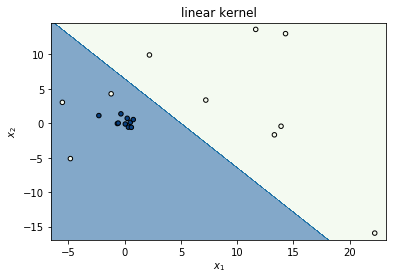

In [5]:
# SVC with linear kernel
clf = sklearn.svm.SVC(kernel='linear')
clf.fit(Xtrain, ytrain)

# Training error
yfit = clf.predict(Xtrain)
err_train = error(yfit, ytrain)
print('Training error = ', err_train)

# Testing error
ypred = clf.predict(Xtest)
err_test = error(ypred, ytest)
print('Testing error = ', err_test)

# Visualization
fig = plt.figure()
X0, X1 = Xtrain[:, 0], Xtrain[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(clf, xx, yy, cmap=plt.cm.GnBu, alpha=0.5)
plt.scatter(X0, X1, c=ytrain, cmap=plt.cm.GnBu, s=20, edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('linear kernel')
plt.show()

Training error =  0.0
Testing error =  0.068


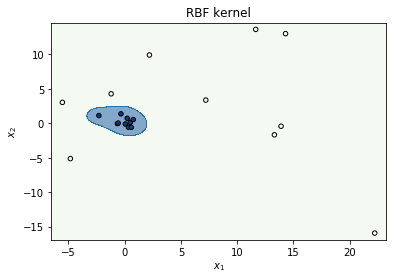

In [6]:
# SVC with RBF kernel
clf = sklearn.svm.SVC(kernel='rbf')
clf.fit(Xtrain, ytrain)

# Training error
yfit = clf.predict(Xtrain)
err_train = error(yfit, ytrain)
print('Training error = ', err_train)

# Testing error
ypred = clf.predict(Xtest)
err_test = error(ypred, ytest)
print('Testing error = ', err_test)

# Visualization
fig = plt.figure()
X0, X1 = Xtrain[:, 0], Xtrain[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(clf, xx, yy, cmap=plt.cm.GnBu, alpha=0.5)
plt.scatter(X0, X1, c=ytrain, cmap=plt.cm.GnBu, s=20, edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('RBF kernel')
plt.show()

Text(0.5,0,'Median heuristic')

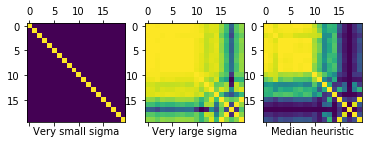

In [7]:
# RBF kernels with different sigma
# Transform sigma to gamma used by sklearn
gam = lambda sig: 1/(2*sig*sig)

# sigma very small, very large and median heuristic
keyL = ['Very small sigma', 'Very large sigma', 'Median heuristic']
sigL = [1e-6, 1e6, np.median(sklearn.metrics.pairwise.euclidean_distances(Xtrain))]
KL = [sklearn.metrics.pairwise.rbf_kernel(Xtrain, gamma=gam(sig)) for sig in sigL]

# Plot
fig, (ax0, ax1, ax2) = plt.subplots(1,3)
ax0.matshow(KL[0])
ax0.set_xlabel(keyL[0])
ax1.matshow(KL[1])
ax1.set_xlabel(keyL[1])
ax2.matshow(KL[2])
ax2.set_xlabel(keyL[2])

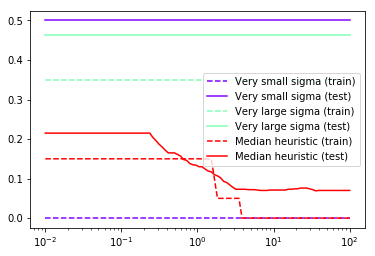

In [8]:
# Train-test error curve
plt.figure()
CL = 10**np.linspace(-2,2,100)
cols = plt.cm.rainbow(np.linspace(0,1,len(sigL)))
for j,sig in enumerate(sigL):
    err_train = np.zeros(len(CL))
    err_test = np.zeros(len(CL))
    
    for i,C in enumerate(CL):
        clf = sklearn.svm.SVC(kernel='rbf',gamma=gam(sig),C=C)
        clf.fit(Xtrain, ytrain)
        yfit = clf.predict(Xtrain)
        err_train[i] = error(yfit, ytrain)
        ypred = clf.predict(Xtest)
        err_test[i] = error(ypred, ytest)
        
    plt.plot(CL, err_train, linestyle='--', color=cols[j], label=keyL[j]+' (train)')
    plt.plot(CL, err_test, linestyle='-', color=cols[j], label=keyL[j]+' (test)')
    
plt.legend()
plt.xscale('log')
plt.show()

In [9]:
# Two ways to train a SVC with RBF kernel
# I. With feature matrix
clf1 = sklearn.svm.SVC(kernel='rbf', gamma=1, C=1)
clf1.fit(Xtrain, ytrain)
ymar1 = clf1.decision_function(Xtest)

# II. With kernel matrix
Ktrain = sklearn.metrics.pairwise.rbf_kernel(Xtrain, Xtrain, gamma=1)
clf2 = sklearn.svm.SVC(kernel='precomputed', C=1)
clf2.fit(Ktrain, ytrain)
Ktest = sklearn.metrics.pairwise.rbf_kernel(Xtest, Xtrain, gamma=1)
ymar2 = clf2.decision_function(Ktest)

# Compare
np.sum((ymar1-ymar2)**2)

2.2648396885609465e-28

### Kernel Approximation

In [10]:
# Simulate data
np.random.seed(54321)
p = 2

# Training data
ntrain = 1000
ntrain_pos = int(ntrain/2)
ntrain_neg = ntrain - ntrain_pos
Xtrain = np.vstack([np.random.normal(0,1,(ntrain_pos,p)),
                    np.random.normal(0,10,(ntrain_neg,p))])
ytrain = np.concatenate([np.repeat(1,ntrain_pos),
                         np.repeat(-1,ntrain_neg)])

# Testing data
ntest = 1000
ntest_pos = int(ntest/2)
ntest_neg = ntest - ntest_pos
Xtest = np.vstack([np.random.normal(0,1,(ntest_pos,p)),
                   np.random.normal(0,10,(ntest_neg,p))])
ytest = np.concatenate([np.repeat(1,ntest_pos),
                        np.repeat(-1,ntest_neg)])

In [11]:
# Exact kernel vs Nystrom approximation
gam = 0.01
C = 1
q = 100

# I. Exact kernel
print('Using exact kernel:')
clf = sklearn.svm.SVC(kernel='rbf', gamma=gam, C=C)
clf.fit(Xtrain, ytrain)
# Training error
yfit = clf.predict(Xtrain)
err_train = error(yfit, ytrain)
print('Training error = ', err_train)
# Testing error
ypred = clf.predict(Xtest)
err_test = error(ypred, ytest)
print('Testing error = ', err_test)

# II. Nystrom approximation
print('Using Nystrom approximation:')
# Nystrom transformer
map_nystrom = Nystroem(kernel='rbf', gamma=gam, random_state=1, n_components=q)
# Transform training and testing data
Xtrain_approx = map_nystrom.fit_transform(Xtrain)
Xtest_approx = map_nystrom.fit_transform(Xtest)
# Fitting linear SVM
clf = sklearn.svm.SVC(kernel='linear', C=C)
clf.fit(Xtrain_approx, ytrain)
# Training error
yfit = clf.predict(Xtrain_approx)
err_train = error(yfit, ytrain)
print('Training error = ', err_train)
# Testing error
ypred = clf.predict(Xtest_approx)
err_test = error(ypred, ytest)
print('Testing error = ', err_test)

Using exact kernel:
Training error =  0.038
Testing error =  0.047
Using Nystrom approximation:
Training error =  0.037
Testing error =  0.046


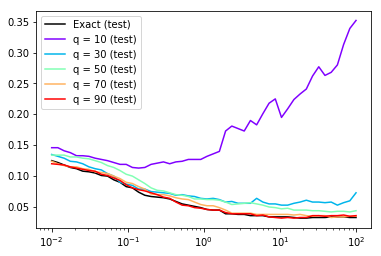

In [12]:
# (Train-)test error curve for list of q
gam = 0.01
qL = np.arange(10,100,20)
CL = 10**np.linspace(-2,2,50)

# I. Using exact kernel matrix
plt.figure()
err_train = np.zeros(len(CL))
err_test = np.zeros(len(CL))
for i,C in enumerate(CL):
    clf = sklearn.svm.SVC(kernel='rbf',gamma=gam,C=C)
    clf.fit(Xtrain, ytrain)
    yfit = clf.predict(Xtrain)
    err_train[i] = error(yfit, ytrain)
    ypred = clf.predict(Xtest)
    err_test[i] = error(ypred, ytest)
# plt.plot(CL, err_train, linestyle='--', color='black', label='Exact (train)')
plt.plot(CL, err_test, linestyle='-', color='black', label='Exact (test)')

# II. Using approximate kernel matrices
cols = plt.cm.rainbow(np.linspace(0,1,len(qL)))
for j,q in enumerate(qL):
    err_train = np.zeros(len(CL))
    err_test = np.zeros(len(CL))
    
    # Transform training and testing data
    map_nystrom = Nystroem(kernel='rbf', gamma=gam, random_state=1, n_components=q)
    Xtrain_approx = map_nystrom.fit_transform(Xtrain)
    Xtest_approx = map_nystrom.fit_transform(Xtest)
    
    for i,C in enumerate(CL):
        # Fitting linear SVM
        clf = sklearn.svm.SVC(kernel='linear', C=C)
        clf.fit(Xtrain_approx, ytrain)
        yfit = clf.predict(Xtrain_approx)
        err_train[i] = error(yfit, ytrain)
        ypred = clf.predict(Xtest_approx)
        err_test[i] = error(ypred, ytest)
    # plt.plot(CL, err_train, linestyle='--', color=cols[j], label='q = '+str(q)+' (train)')
    plt.plot(CL, err_test, linestyle='-', color=cols[j], label='q = '+str(q)+' (test)')

plt.legend()
plt.xscale('log')
plt.show()